# Step 1: Install All the Required Packages

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

# Step 2: Import All the Required Libraries

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
import os
import torch
import numpy as np
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer

# In case of Llama 2, the following prompt template is used for the chat **models**

System Prompt (optional) to guide the model \
User prompt (required) to give the instruction\
Model Answer (required)

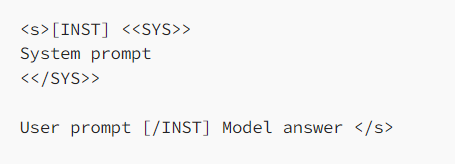

# We will reformat our instruction dataset to follow the Llama 2 template.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
#model_name = "NousResearch/Llama-2-7b-chat-hf"
model_name = "xz97/AlpaCare-llama2-7b"

# The instruction dataset to use
dataset_name = "mi-rei/date_accurate"

# Fine-tuned model name
new_model = "Alpacare-date-accurate"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
# since it works on similarity
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters (supervised tuning)
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load data correctly and create train, val, test split
train_dataset = load_dataset(dataset_name, split="train")
train_dataset[0]

test_dataset = load_dataset(dataset_name, split="test")
test_dataset[0]

# save out a list of unique post_ids for the training and then dev sets
# split train 70%/ dev 15% / test 15%

# split twice and combine
train_set = train_dataset.train_test_split(shuffle = True, seed = 42, test_size=0.1875)
#val_test = train_temp['test'].train_test_split(shuffle = True, seed = 42, test_size=0.25)

train_val_test = DatasetDict({
    'train': train_set['train'],
    'val': train_set['test'],
    'test': test_dataset})
train_val_test

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4062
    })
    val: Dataset({
        features: ['text'],
        num_rows: 938
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1250
    })
})

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = metric.compute(predictions=predictions, references=labels, average='macro')["f1"]
    return {"f1": f1}


# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_val_test['train'],
    eval_dataset=train_val_test['val'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    #compute_metrics=compute_metrics  # Pass compute_metrics function
)
model = torch.compile(model)
# Train model
trainer.train()

# Extract F1 score from metrics dictionary
#eval_f1_score = train_output.metrics['eval_f1']
#print("F1 score on eval set:", eval_f1_score)

Your GPU supports bfloat16: accelerate training with bf16=True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/643 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/4062 [00:00<?, ? examples/s]

Map:   0%|          | 0/938 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss


In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

<IPython.core.display.Javascript object>

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             classification_report,
                             confusion_matrix)

def evaluate(y_true, y_pred):
    labels = ['Yes', 'No']
    mapping = {'Yes': 1, 'No': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Calculate F1-Score
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    print(f'F1 Score: {f1:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [ ]:
# Load pretrained model
model_name = "mi-rei/AlpaCare-llama2-7b-CT_I-II-III_efficient"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

In [1]:
# Test functionality

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
sys = "Predict if this trial will transition to the next phase. Return the answer as the corresponding label: Yes or No. Do not repeat the input."
prompt = "TRIAL NAME: Phase III - Treatment IND; BRIEF: Single arm, open-label study to provide Defibrotide to patients diagnosed with VOD. Defibrotide is no longer available though the Emergency Use IND mechanism (also known as compassionate use, or single patient named use). This protocol is the only mechanism by which Defibrotide can be made available to patients in the U.S. ; DRUG USED: Defitelio; DRUG CLASS: New Molecular Entity (NME); INDICATION: Sinusoidal Obstruction Syndrome (Veno-Occlusive Disease / VOD); TARGET: Eicosanoids; THERAPY: Monotherapy; LEAD SPONSOR: Jazz Pharmaceuticals; CRITERIA: Inclusion Criteria: Entry criteria include the following: 1. Clinical diagnosis of VOD, made by Baltimore Criteria, Modified Seattle Criteria, or biopsy proven: 1.1 Baltimore Criteria- Bilirubin ≥2 mg/dL and at least 2 of the following clinical findings: - Ascites (radiographic or physical exam) - Weight gain of ≥5% compared to the day of conditioning-- if this value is not available, the weight on the date of admission to the SCT unit may be used) - Hepatomegaly; increased over baseline. 1.2 Modified Seattle Criteria: At least two of the following - Bilirubin ≥2 mg/dL - Ascites (radiographic or physical exam) and/or weight gain ≥5% above baseline weight (defined as weight on the first day of conditioning- if this value is not available, the weight on the date of admission to the SCT unit may be used) - hepatomegaly increased over baseline 1.3 Patients that do not meet the Baltimore Criteria or Modified Seattle Criteria and have biopsy proven VOD are eligible. 2. Patient must also provide written informed consent. Exclusion Criteria: - Use of any medication which increases the risk of hemorrhage is disallowed. Use of heparin or other anticoagulants is disallowed within 12 hours unless being used for routine central venous line management, fibrinolytic instillation for central venous line occlusion, intermittent dialysis or ultrafiltration of CVVH. - Clinically significant uncontrolled acute bleeding, defined as hemorrhage requiring > 15 cc/kg of packed red blood cells (e.g., a pediatric patient weighing 20 kg and requiring > 300cc of packed red blood cells/24 hours, or an adult patient weighing 70 kg and requiring >3 units of packed red blood cells/24 hours) to replace blood loss, OR bleeding from a site which in the Investigators opinion constitutes a potential life-threatening source (e.g. pulmonary hemorrhage or CNS bleeding), irrespective of amount of blood loss, at any point from the date of SCT through the date of severe VOD diagnosis. - Hemodynamic instability as defined by a requirement for multiple pressors, or inability to maintain mean arterial pressure (for children: to maintain mean arterial pressure within 1 standard deviation of age-adjusted levels) with single pressor support. - Woman who are pregnant. ; PRIMARY OUTCOME: Survival by Day+100 Post Stem Cell Transplant or Chemotherapy; SECONDARY OUTCOME 1: "
# should be Yes
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1, temperature=0.2)
result = pipe(f"<s>[INST]<<SYS>> {sys} <</SYS>> {prompt} [/INST]")
generated_text = result[0]['generated_text']
print(generated_text)

import re
#pattern = re.compile(r'\[/INST\](.*?)</s>', re.DOTALL)
pattern = re.compile(r'\b(\w+)\s*$', re.DOTALL)
matches = pattern.search(generated_text)

if matches:
    extracted_text = matches.group(1).strip()
    print(extracted_text)
else:
    print("No match found.")

NameError: name 'logging' is not defined

In [ ]:
# Create y_true
import re

# Initialize an empty list to store the extracted texts
y_true = []

# Define the pattern for text extraction
pattern = re.compile(r'\[/INST\](.*?)</s>', re.DOTALL)

# Loop through each entry in train_val_test['test']
for entry in train_val_test['test']:
    text = entry['text']
    matches = pattern.search(text)
    if matches:
        extracted_text = matches.group(1).strip()
        y_true.append(extracted_text)
    else:
        y_true.append('None')  # or any other placeholder value if no match is found

# Print the extracted texts
print(len(y_true))
print(y_true)

4017
['Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes',

In [ ]:
# Create y_pred

def GetPrompt(text):
  # Define the pattern for text extraction
  pattern = re.compile(r'<<\/SYS>>(.*?)\[\/INST\]', re.DOTALL)
  matches = pattern.search(text)

  if matches:
      extracted_prompt = matches.group(1).strip()
      #print(extracted_text)
  else:
    extracted_prompt = None
      #print(None)
  return extracted_prompt

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

import re
sys = "Predict if this trial will transition to the next phase. Return the answer as the corresponding label: Yes or No. Do not repeat the input."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1)

# Initialize an empty list to store the extracted texts
y_pred = []

# Define the pattern for text extraction
#pattern = re.compile(r'\[/INST\](.*?)</s>', re.DOTALL)
pattern = re.compile(r'\b(\w+)\s*$', re.DOTALL)

# Loop through each entry in train_val_test['test']
for entry in train_val_test['test']:
    #print(" ")
    prompt = entry['text']
    #print(prompt)
    #pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=len(prompt))
    prompt = GetPrompt(prompt)
    #print(prompt)
    result = pipe(f"<s>[INST]<<SYS>> {sys} <</SYS>> {prompt} [/INST]")
    generated_text = result[0]['generated_text']
    #print(generated_text)
    matches = pattern.search(generated_text)
    if matches:
        predicted_label = matches.group(1).strip()
        print(predicted_label)
        y_pred.append(predicted_label)
    else:
        y_pred.append('None')  # or any other placeholder value if no match is found

# Print the extracted texts
print(len(y_pred))
print(y_pred)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


No
Yes
No
No
No
Yes
No
Yes
Yes
Yes


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Yes
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
Yes
No
Yes
No
No
No
Yes
No
Yes
No
Yes
No
No
Yes
No
No
No
Yes
Yes
No
No
Yes
Yes
No
Yes
No
No
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
No
Yes
Yes
No
Yes
Yes
No
No
No
No
Yes
Yes
No
No
No
No
Yes
No
Yes
Yes
Yes
No
Yes
Yes
No
No
No
Yes
No
No
Yes
No
Yes
Yes
No
Yes
No
No
Yes
No
Yes
Yes
Yes
No
No
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
Yes
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
Yes
No
No
Yes
Yes
No
Yes
Yes
No
Yes
No
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
No
Yes
No
Yes
Yes
Yes
No
Yes
Yes
No
No
Yes
Yes
No
No
Yes
No
No
No
Yes
Yes
No
Yes
Yes
Yes
No
Yes
No
Yes
No
No
Yes
Yes
No
Yes
Yes
No
No
No
No
No
Yes
No
No
Yes
Yes
No
Yes
Yes
No
No
Yes
Yes
No
No
No
No
No
No
Yes
Yes
No
No
Yes
Yes
Yes
No
Yes
No
Yes
Yes
No
No
Yes
No
Yes
Yes
No
No
Yes
Yes
No
No
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
No
No
No
No
Yes
Yes
No
No
Yes
No
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
N

In [ ]:
# evaluate performance of model

evaluate(y_true, y_pred)

Accuracy: 0.615
F1 Score: 0.625
Accuracy for label 0: 0.588
Accuracy for label 1: 0.642

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60      1001
           1       0.61      0.64      0.62       999

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[589 412   0]
 [358 641   0]
 [  0   0   0]]


In [ ]:
# Special experiment
# Evaluate different phases

import re

# Initialize an empty list to store the extracted texts
y_true_phase_iii = []
y_true_phase_ii = []
y_true_phase_i = []

filtered_ii = []
filtered_i = []

# Define the pattern for text extraction
pattern_iii = re.compile(r'TRIAL NAME: Phase III(.*?)</s>', re.DOTALL)
pattern_ii = re.compile(r'TRIAL NAME: Phase II(.*?)</s>', re.DOTALL)
pattern_i = re.compile(r'TRIAL NAME: Phase I(.*?)</s>', re.DOTALL)

# Loop through each entry in train_val_test['test']
for entry in train_val_test['test']:
    text = entry['text']
    matches = pattern_iii.search(text)
    if matches:
        y_true_phase_iii.append(text)
    else:
      filtered_ii.append(text)

for entry in filtered_ii:
    text = entry
    matches = pattern_ii.search(text)
    if matches:
        y_true_phase_ii.append(text)
    else:
      filtered_i.append(text)

for entry in filtered_i:
    text = entry
    matches = pattern_i.search(text)
    if matches:
        y_true_phase_i.append(text)

# Print the number of extracted texts and the extracted texts themselves
print(len(y_true_phase_iii))
print(y_true_phase_iii[0])
#print(y_true_phase_iii)
print(len(y_true_phase_ii))
print(y_true_phase_ii[0])

print(len(y_true_phase_i))
print(y_true_phase_i[0])

1127
<s>[INST]<<SYS>>Predict if this trial will transition to the next phase. Return the answer as the corresponding label: Yes or No.<</SYS>>TRIAL NAME: Phase III - REVISE (0091); BRIEF: This trial is to determine whether Juvista can prevent scar formation or improve the appearance of scars following scar revision surgery. The trial will involve comparing Juvista to placebo. ; DRUG USED: Juvista; DRUG CLASS: Biologic; INDICATION: Wound Healing; TARGET: Transforming Growth Factor-beta (TGF-beta) and Superfamily; THERAPY: Monotherapy; LEAD SPONSOR: Renovo; CRITERIA: Inclusion Criteria: - Patients aged 18-85 years who have provided written informed consent. - BMI between 15 and 35 kg/m2 - Patients with, in the opinion of the Investigator, clinically acceptable results for the laboratory tests specified in the trial protocol. - If females of child bearing potential, patients must be using a highly effective method(s) of contraception and agree to do so from at least the screening visit un

In [ ]:
# Create y_true
import re

phase_set = y_true_phase_i[:500]

# Initialize an empty list to store the extracted texts
y_true = []

# Define the pattern for text extraction
pattern = re.compile(r'\[/INST\](.*?)</s>', re.DOTALL)

# Loop through each entry in train_val_test['test']
for entry in phase_set:
    text = entry
    matches = pattern.search(text)
    if matches:
        extracted_text = matches.group(1).strip()
        y_true.append(extracted_text)
    else:
        y_true.append('None')  # or any other placeholder value if no match is found

# Print the extracted texts
print(len(y_true))
print(y_true)

500
['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No',

In [ ]:
# Create y_pred

def GetPrompt(text):
  # Define the pattern for text extraction
  pattern = re.compile(r'<<\/SYS>>(.*?)\[\/INST\]', re.DOTALL)
  matches = pattern.search(text)

  if matches:
      extracted_prompt = matches.group(1).strip()
      #print(extracted_text)
  else:
    extracted_prompt = None
      #print(None)
  return extracted_prompt

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

import re
sys = "Predict if this trial will transition to the next phase. Return the answer as the corresponding label: Yes or No. Do not repeat the input."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1)

# Initialize an empty list to store the extracted texts
y_pred = []

# Define the pattern for text extraction
#pattern = re.compile(r'\[/INST\](.*?)</s>', re.DOTALL)
pattern = re.compile(r'\b(\w+)\s*$', re.DOTALL)

# Loop through each entry in train_val_test['test']
for entry in phase_set:
    #print(" ")
    prompt = entry
    #print(prompt)
    #pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=len(prompt))
    prompt = GetPrompt(prompt)
    #print(prompt)
    result = pipe(f"<s>[INST]<<SYS>> {sys} <</SYS>> {prompt} [/INST]")
    generated_text = result[0]['generated_text']
    #print(generated_text)
    matches = pattern.search(generated_text)
    if matches:
        predicted_label = matches.group(1).strip()
        print(predicted_label)
        y_pred.append(predicted_label)
    else:
        y_pred.append('None')  # or any other placeholder value if no match is found

# Print the extracted texts
print(len(y_pred))
print(y_pred)

Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
Yes
No
Yes
RE
No
Yes
Yes
No
Yes
Yes
No
No
Yes
Yes
Yes
No
No
No
No
Yes
Yes
No
Yes
Yes
Yes
No
Yes
Yes
No
No
No
No
No
No
Yes
No
No
No
No
Yes
No
No
Yes
Yes
No
Yes
Yes
No
No
Yes
Yes
Yes
No
Yes
Yes
Yes
No
Yes
Yes
No
Yes
Yes
Yes
No
G
Yes
No
Yes
No
Yes
No
Yes
Yes
No
Yes
No
No
No
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
No
No
No
No
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
No
Yes
No
Yes
Yes
No
No
Yes
Pro
No
No
Yes
No
Yes
Yes
U
Yes
Yes
Yes
Yes
No
No
Yes
Yes
No
No
No
No
Yes
No
No
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
No
No
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
Yes
Yes
No
No
No
Yes
Yes
No
Yes
No
No
No
Yes
No
Yes
No
No
Yes
Yes
Yes
No
No
Yes
No
No
Yes
Yes
No
Yes
No
No
No
Yes
Yes
No
No
Yes
No
No
No
Yes
Yes
Yes
Yes
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
Yes
No
Yes
Yes
No
No
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
w
Yes
No
Yes
w
No
No
Yes
No
Yes
Yes

In [ ]:
y_pred_III = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'MS', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'V', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'M', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Par', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'An', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No']

In [ ]:
y_pred_II = []

In [ ]:
evaluate(y_true, y_pred)

Accuracy: 0.572
F1 Score: 0.561
Accuracy for label 0: 0.502
Accuracy for label 1: 0.675

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.50      0.58       297
           1       0.48      0.67      0.56       203

    accuracy                           0.57       500
   macro avg       0.59      0.59      0.57       500
weighted avg       0.61      0.57      0.57       500


Confusion Matrix:
[[149 148   0]
 [ 66 137   0]
 [  0   0   0]]


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

NameError: name 'model' is not defined

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [ ]:
file_name = "mi-rei/" + new_model

model.push_to_hub(file_name, check_pr=True)

tokenizer.push_to_hub(file_name, check_pr=True)